In [1]:
import reciprocalspaceship as rs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import gemmi as gm
import seaborn as sns
import matplotlib.gridspec as gridspec
import seaborn as sns

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 18,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)
directory_search_pattern = "careless_runs/" #directory in which to search for tabular outputs. 

This notebook is for calculating, compiling, and visualizing merging statistics. 

In [2]:
def get_careless_params(dirpath):
#     print(os.path.join(dirpath, 'inputs_params.log'))
    with open(os.path.join(dirpath, 'inputs_params.log')) as params:
        line = params.readline()
        line = params.readline()
        args_list=line.split('--')
#             print(args_list)
        p_={}
        bDisableImageScale=False
        for tag in args_list:
            if 'dmin' in tag:
                p_['DMIN']=tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-frequencies' in tag:
                p_['PEF'] =tag.split('=')[1].split(' ')[0]
            if 'iterations' in tag:
                p_['ITER']=tag.split('=')[1].split(' ')[0]
            if 'mlp-layers' in tag:
                p_['MLPL']=tag.split('=')[1].split(' ')[0]
            if 'studentt-likelihood-dof' in tag:
                p_['STDOF'] =tag.split('=')[1].split(' ')[0]
            if 'image-layers' in tag:
                p_['IL']  =tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-keys' in tag:
                p_['PE-keys']=tag.split('=')[1].split(' ')[0]
            if 'seed' in tag:
                p_['SEED']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-parents' in tag:
                p_['DW_list']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-r' in tag:
                DWr_list = tag.split('=')[1]
                p_['rDW']  = DWr_list.split(',')[-1]
            if 'disable-image-scales' in tag:
                bDisableImageScale=True
            if 'refine-uncertainties' in tag:
                p_['RU']=1
        if bDisableImageScale:
            p_['IL']=-1
        if 'STDOF' not in p_:
            p_['STDOF']=-1
        if 'RU' not in p_:
            p_['RU']=0
        if 'PEF' not in p_:
            p_['PEF']=0
        if 'rDW' not in p_:
            p_['rDW']=-1
        run_param=pd.DataFrame(data=p_,index=[0])
        run_param.DMIN  = run_param.DMIN.astype( 'float')
        run_param.SEED  = run_param.SEED.astype( 'int64')
        run_param.ITER  = run_param.ITER.astype( 'int64')
        run_param.STDOF = run_param.STDOF.astype('float')
        run_param.RU    = run_param.RU.astype(   'int64')
        run_param.MLPL  = run_param.MLPL.astype( 'int64')
        run_param.IL    = run_param.IL.astype(   'int64')
        run_param.rDW   = run_param.rDW.astype(  'float')
        run_param.PEF   = run_param.PEF.astype(  'int64')
        return run_param

### Run scripts to calculate merging statistics

We calculate merging statistics with a set of scripts in `./scripts`. repeats for the CCpred calculation are found in `careless_runs_pred`. 

In [3]:
!pwd

/n/hekstra_lab/projects/dw-examples/lysozyme_test_fraction


In [4]:
%%bash

sh ./scripts/1_HEWL_anom_unfriedelize.sh

In [29]:
%%bash

sh ./scripts/2_HEWL_anom_refine.sh

Submitted batch job 28279009
Submitted batch job 28279010
Submitted batch job 28279011


In [39]:
%%bash

sh ./scripts/3_HEWL_anom_peak_heights.sh

Traceback (most recent call last):
  File "/n/hekstra_lab/projects/dw-examples/lysozyme_test_fraction/./scripts/concatenate_anomalous_peak_csv.py", line 48, in <module>
    main()
  File "/n/hekstra_lab/projects/dw-examples/lysozyme_test_fraction/./scripts/concatenate_anomalous_peak_csv.py", line 45, in main
    concat_anom_peak_csv(sys.argv[1], frames_list, csv_list)
  File "/n/hekstra_lab/projects/dw-examples/lysozyme_test_fraction/./scripts/concatenate_anomalous_peak_csv.py", line 23, in concat_anom_peak_csv
    overall_row_2 = [frames_list[i]] + peak_height    
                     ~~~~~~~~~~~^^^
IndexError: list index out of range


CalledProcessError: Command 'b'\nsh ./scripts/3_HEWL_anom_peak_heights.sh\n'' returned non-zero exit status 1.

In [5]:
params_list=[]
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('peak_heights.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'peak_heights.csv'))
#         print(tmp)
        
        try:
            print(dirpath)

            tmp_id=dirpath.split('_')[-4][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-1]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
#             tmp_r=np.nan
        careless_params=get_careless_params(dirpath)
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id

        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        results_list.append(tmp)
        params_list.append(careless_params)
all_params =pd.concat(params_list)
all_results_peak_heights=pd.concat(results_list)

./careless_runs/phenix_poly_dw_mlp32_PEF_R0.98438_0720_dmin1pt8_0
Read-in values of grid_id: 0.98438,  job_id: 0
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.50000_0720_dmin1pt8_1
Read-in values of grid_id: 0.50000,  job_id: 1
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.96875_0720_dmin1pt8_2
Read-in values of grid_id: 0.96875,  job_id: 2
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.99951_0720_dmin1pt8_2
Read-in values of grid_id: 0.99951,  job_id: 2
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.99609_0720_dmin1pt8_2
Read-in values of grid_id: 0.99609,  job_id: 2
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.99951_0720_dmin1pt8_0
Read-in values of grid_id: 0.99951,  job_id: 0
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.75000_0720_dmin1pt8_1
Read-in values of grid_id: 0.75000,  job_id: 1
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.96875_0720_dmin1pt8_0
Read-in values of grid_id: 0.96875,  job_id: 0
./careless_runs/phenix_poly_dw_mlp32_PEF_R0.99219_0720_dmin1pt8_2
Read-in values of grid_id: 0.9

In [6]:
all_results_peak_heights.rename(columns={"grid_id":"rDW"}, inplace=True)

In [7]:
all_results_peak_heights["rDW"] = all_results_peak_heights["rDW"].astype("float")

In [8]:
iodines

NameError: name 'iodines' is not defined

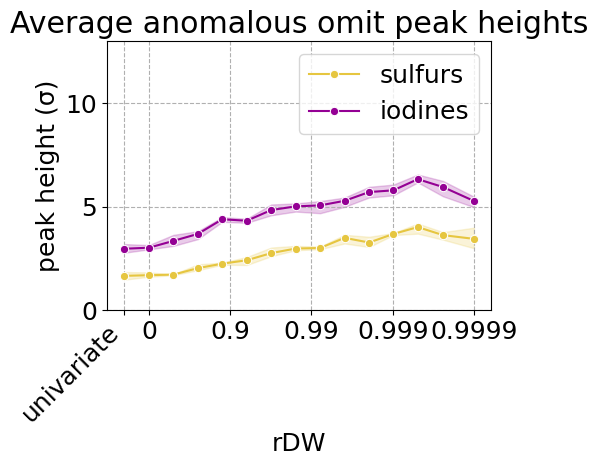

In [9]:
sulfur_atoms = []
iodine_atoms = []
for name in all_results_peak_heights.columns:
    if name[:3] == "IOD":
        iodine_atoms.append(name)
    elif name[:3] in ["CYS","MET"]:
        sulfur_atoms.append(name)

iodines = all_results_peak_heights[iodine_atoms].mean(axis=1)#.to_numpy()
sulfurs = all_results_peak_heights[sulfur_atoms].mean(axis=1)#.to_numpy()

new_df = pd.DataFrame({"rDW":np.log10(1-all_results_peak_heights["rDW"]),"sulfurs":sulfurs,"iodines":iodines})


fig,ax = plt.subplots(figsize=[5.5,5])
plt.grid(linestyle="--")

sns.lineplot(data = new_df, x = "rDW", y = "sulfurs",marker="o",linestyle="-",c=(0.9,0.775,0.25),label="sulfurs")
sns.lineplot(data = new_df, x = "rDW", y = "iodines",marker="o",linestyle="-",c=(0.580392157,0.0,0.580392157),label="iodines")


plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
ax.set_ylim([0,13])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='upper right')
plt.title("Average anomalous omit peak heights")
plt.ylabel("peak height (σ)")
plt.tight_layout()
plt.savefig("average_peak_heights.svg",bbox_inches="tight")
plt.show()

# Importing $CC_\text{pred}$

We now import overall CCpred values from each of the repeats. 

In [47]:
count=0
results_list=[]
params_list=[]
id_list=[]

directory_search_pattern_pred= "careless_runs_pred/" 
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccpred_overall_careless.csv' in filenames) and (directory_search_pattern_pred in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccpred_overall_careless.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        results_list.append(tmp)
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        params_list.append(careless_params)

all_params =pd.concat(params_list)
all_results_ccpred=pd.concat(results_list)

./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.99976_0720_dmin1.8_56480946_poly
Read-in values of grid_id: 0.99976,  job_id: 56480946
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.93750_0720_dmin1.8_56480211_poly
Read-in values of grid_id: 0.93750,  job_id: 56480211
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.75000_0720_dmin1.8_56480667_poly
Read-in values of grid_id: 0.75000,  job_id: 56480667
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.96875_0720_dmin1.8_56480212_poly
Read-in values of grid_id: 0.96875,  job_id: 56480212
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.99805_0720_dmin1.8_56480860_poly
Read-in values of grid_id: 0.99805,  job_id: 56480860
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.99902_0720_dmin1.8_56480217_poly
Read-in values of grid_id: 0.99902,  job_id: 56480217
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.99976_0720_dmin1.8_56480243_poly
Read-in values of grid_id: 0.99976,  job_id: 56480243
./careless_runs_pred/merge_HEWL_dw_mlp32_PEF_R0.99902_0

### Importing $CC_\text{1/2}$

We import $CC_\text{1/2}$ values from each of the *half-dataset* repeats in `./careless_runs`. 

In [48]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('cchalf_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'cchalf_overall.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        
        results_list.append(tmp)
all_results_cchalf=pd.concat(results_list)

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0720_dmin1.8_57282505_poly
Read-in values of grid_id: 0.98438,  job_id: 57282505
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.87500_0720_dmin1.8_57282470_poly
Read-in values of grid_id: 0.87500,  job_id: 57282470
./careless_runs/merge_HEWL_dw_mlp32_PEF_R-1.0000_0720_dmin1.8_57282466_poly
Read-in values of grid_id: -1.0000,  job_id: 57282466
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0720_dmin1.8_57282511_poly
Read-in values of grid_id: 0.99976,  job_id: 57282511
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99219_0720_dmin1.8_57282506_poly
Read-in values of grid_id: 0.99219,  job_id: 57282506
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0720_dmin1.8_57282503_poly
Read-in values of grid_id: 0.93750,  job_id: 57282503
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0720_dmin1.8_57282508_poly
Read-in values of grid_id: 0.99805,  job_id: 57282508
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0720_dmin1.8_57282510_poly
Read-in values

### Importing $CC_\text{anom}$

We import $CC_\text{anom}$ values from each of the *half-dataset* repeats in `./careless_runs`. 

In [49]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccanom_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccanom_overall.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        
        results_list.append(tmp)
all_results_ccanom=pd.concat(results_list)

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0720_dmin1.8_57282505_poly
Read-in values of grid_id: 0.98438,  job_id: 57282505
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.87500_0720_dmin1.8_57282470_poly
Read-in values of grid_id: 0.87500,  job_id: 57282470
./careless_runs/merge_HEWL_dw_mlp32_PEF_R-1.0000_0720_dmin1.8_57282466_poly
Read-in values of grid_id: -1.0000,  job_id: 57282466
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0720_dmin1.8_57282511_poly
Read-in values of grid_id: 0.99976,  job_id: 57282511
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99219_0720_dmin1.8_57282506_poly
Read-in values of grid_id: 0.99219,  job_id: 57282506
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0720_dmin1.8_57282503_poly
Read-in values of grid_id: 0.93750,  job_id: 57282503
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0720_dmin1.8_57282508_poly
Read-in values of grid_id: 0.99805,  job_id: 57282508
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0720_dmin1.8_57282510_poly
Read-in values

### Importing anomalous peak heights

We now import anomalous peak heights per csv file generated by `3_HEWL_anom_peak_heights.sh`.

In [50]:
all_results_peak_heights=pd.read_csv("HEWL_anom_peak_heights.csv").rename(columns={"frames":"grid_id"})

In [51]:
all_results_peak_heights["grid_id"]=all_results_peak_heights["grid_id"].round(5)

In [52]:
all_results_peak_heights = all_results_peak_heights.sort_values(by="grid_id")
all_results_peak_heights.rename(columns={"grid_id":"rDW"}, inplace=True)
#all_results_peak_heights.set_index("rDW", inplace=True)

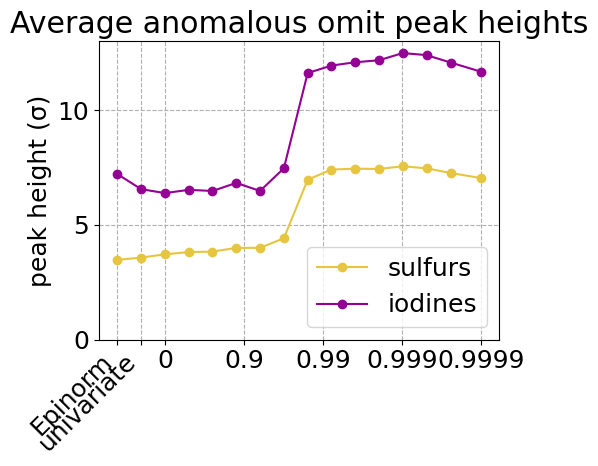

In [53]:
sulfur_atoms = []
iodine_atoms = []
for name in all_results_peak_heights.columns:
    if name[:3] == "IOD":
        iodine_atoms.append(name)
    else:
        sulfur_atoms.append(name)

iodines = all_results_peak_heights[iodine_atoms].mean(axis=1).to_numpy()
sulfurs = all_results_peak_heights[sulfur_atoms].mean(axis=1).to_numpy()

fig,ax = plt.subplots(figsize=[5.5,5])
plt.plot(np.log10(1-all_results_peak_heights["rDW"]),sulfurs,'o-',c=(0.9,0.775,0.25),label="sulfurs")
plt.plot(np.log10(1-all_results_peak_heights["rDW"]),iodines,'o-',c=(0.580392157,0.0,0.580392157),label="iodines")
plt.grid(linestyle="--")

plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303, 0.606],labels=["0.9999","0.999","0.99","0.9","0","univariate","Epinorm"])
ax.set_ylim([0,13])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ticks[-2].set_rotation(45)
ticks[-2].set_ha("right")
ax.legend(loc='lower right')
plt.title("Average anomalous omit peak heights")
plt.ylabel("peak height (σ)")
plt.tight_layout()
plt.savefig("average_peak_heights.svg",bbox_inches="tight")
plt.show()

In [54]:
sulfurs[-4]/sulfurs[0]

2.1722935827759198

/tmp/ipykernel_1211137/1183610318.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_labels = table.applymap(threshold)


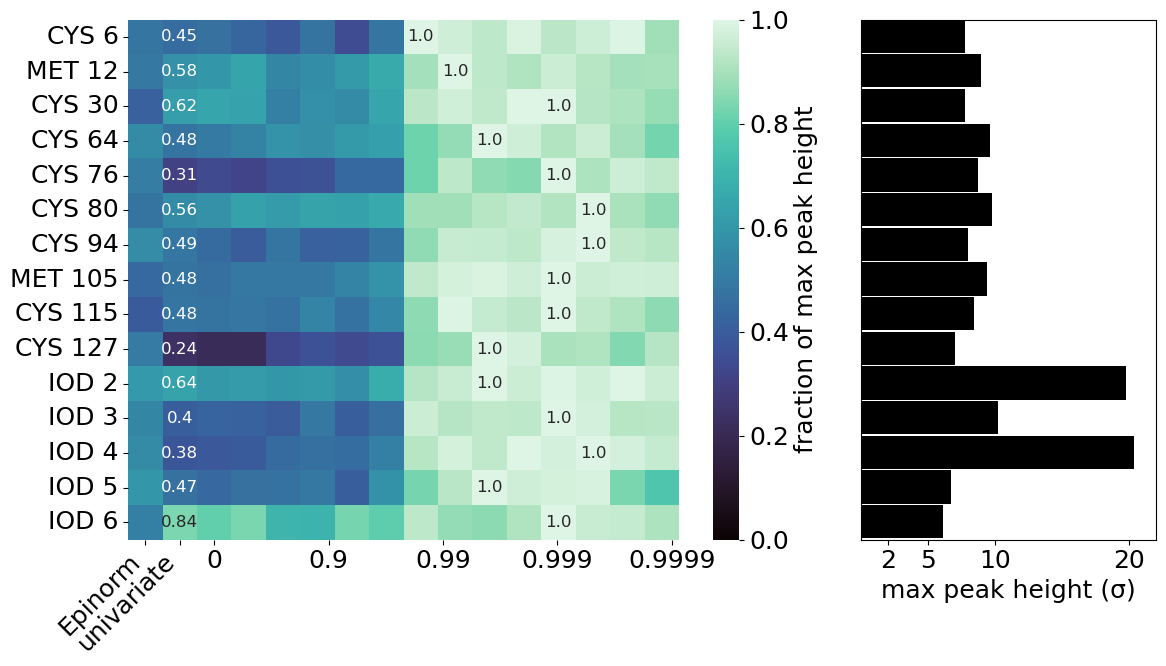

In [55]:
table = all_results_peak_heights.transpose()

table.drop(["rDW"],inplace=True)

max_table = table.max(axis="columns").to_numpy()
table = table.div(max_table, axis='rows')

def threshold(x):
    return '' if x<1 else np.round(x,1)
table_labels = table.applymap(threshold)
table_labels.iloc[:,1] = np.round(table.iloc[:,1],2)

fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 0.3])

ax1 = plt.subplot(gs[0])
sns.heatmap(table, ax=ax1, 
            cmap="mako",
            cbar_kws={'label': 'fraction of max peak height'},
            annot=table_labels,
            annot_kws={"fontsize":12},
            fmt = '')


xticks = (2.5-np.log2(1-np.array([-3,-1,0,0.9,0.99,0.999,0.9999])))
ax1.set_xticks(xticks)
ax1.set_xticklabels(["Epinorm","univariate","0","0.9","0.99","0.999","0.9999"])

ticks = ax1.get_xticklabels()
for ind,tick in enumerate(ticks):
    if ind == 0 or ind == 1:
        tick.set_rotation(45)
        tick.set_ha("right")
    else:
        tick.set_rotation(0)

ax1.collections[0].set_clim(0,1) 

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.barh(table.index, max_table, color='k', height=0.96, align='edge')
ax2.tick_params(left=False, labelleft=False)
#ax2.set_xscale("log")
ax2.set_xlim([0,22])
ax2.set_xticks([2,5,10,20])
ax2.set_xticklabels([2,5,10,20])
ax2.set_xlabel('max peak height (σ)')
plt.tight_layout()
plt.savefig("peak_heights.svg",bbox_inches="tight")

In [56]:
all_results_ccpred = pd.melt(all_results_ccpred, id_vars=['file', 'grid_id','job_id','Resolution Range (Å)','test'], value_vars=['CCpred'])
all_results_ccpred.rename(columns={'value': 'CCpred'}, inplace=True)
pivoted_df = all_results_ccpred.pivot(index=['file', 'grid_id','job_id','Resolution Range (Å)'], columns='test', values='CCpred')
pivoted_df.rename(columns={'Test': 'CCpred_test','Train': 'CCpred_train'}, inplace=True)
all_results_ccpred = pivoted_df.reset_index()

In [57]:
all_results_ccpred

test,file,grid_id,job_id,Resolution Range (Å),CCpred_test,CCpred_train
0,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0000,56480181,39.67 - 1.80,0.936818,0.939531
1,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0000,56480314,39.67 - 1.80,0.938696,0.939409
2,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0000,56481189,39.67 - 1.80,0.937740,0.939261
3,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0000,56480181,39.67 - 1.80,0.936695,0.937662
4,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0000,56480314,39.67 - 1.80,0.936834,0.937721
...,...,...,...,...,...,...
85,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.8_predic...,0.9999,56480957,39.67 - 1.80,0.938208,0.938431
86,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.8_predic...,0.9999,56482982,39.67 - 1.80,0.937942,0.938579
87,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.8_predic...,0.9999,56480256,39.67 - 1.80,0.936944,0.936859
88,HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.8_predic...,0.9999,56480957,39.67 - 1.80,0.937387,0.936708


In [58]:
all_params.reset_index(drop=True,inplace=True)
all_results_ccpred.dropna(inplace=True)
all_results_ccpred["delay"] = [name[-5] for name in all_results_ccpred.file]
all_results_ccpred["delay"]=all_results_ccpred["delay"].astype('int32')
all_results_ccpred.sort_values(by=["grid_id","job_id"],inplace=True)
all_results_ccpred.reset_index(inplace=True)
print(all_results_ccpred.count())
all_results_ccpred.head()

test
index                   90
file                    90
grid_id                 90
job_id                  90
Resolution Range (Å)    90
CCpred_test             90
CCpred_train            90
delay                   90
dtype: int64


test,index,file,grid_id,job_id,Resolution Range (Å),CCpred_test,CCpred_train,delay
0,0,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0,56480181,39.67 - 1.80,0.936818,0.939531,0
1,3,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0,56480181,39.67 - 1.80,0.936695,0.937662,1
2,1,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0,56480314,39.67 - 1.80,0.938696,0.939409,0
3,4,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0,56480314,39.67 - 1.80,0.936834,0.937721,1
4,2,HEWL_dw_mlp32_PEF_R-1_0999_dmin1.8_predictions...,-1.0,56481189,39.67 - 1.80,0.937740,0.939261,0


We clean each of the dataframes generated and then combine them together. First, we compute a mean and standard deviation for the CCpreds.

In [59]:
all_results_ccpred = all_results_ccpred[["grid_id","delay","CCpred_test","CCpred_train"]].groupby(by=["grid_id","delay"])
all_results_ccpred = all_results_ccpred.agg(CCpred_test=("CCpred_test","mean"),
                                            CCpred_test_std=("CCpred_test","std"),
                                            CCpred_train=("CCpred_train","mean"),
                                            CCpred_train_std=("CCpred_train","std"),
                                            grid_id=("grid_id","first"),
                                            delay=("delay","first")).reset_index(drop=True)
all_results_ccpred["grid_id"]=all_results_ccpred["grid_id"].round(5)

In [60]:
all_results_ccpred

,CCpred_test,CCpred_test_std,CCpred_train,CCpred_train_std,grid_id,delay
0,0.937751,0.000939,0.939400,0.000135,-1.00000,0
1,0.936787,0.000080,0.937593,0.000173,-1.00000,1
2,0.938061,0.000674,0.939378,0.000141,0.00000,0
3,0.936465,0.000604,0.937612,0.000068,0.00000,1
4,0.939056,0.000336,0.939366,0.000111,0.50000,0
5,0.936580,0.000561,0.937720,0.000036,0.50000,1
6,0.938581,0.000342,0.939675,0.000038,0.75000,0
7,0.937177,0.000867,0.937929,0.000147,0.75000,1
8,0.938233,0.001112,0.939735,0.000206,0.87500,0
9,0.937497,0.000728,0.937980,0.000032,0.87500,1


In [61]:
def rms(row):
    return np.sqrt(np.sum(row**2))

In [62]:
all_results_ccpred = all_results_ccpred.groupby(by=["grid_id"])
all_results_ccpred = all_results_ccpred.agg(CCpred_test=("CCpred_test","mean"),
                                            CCpred_test_std=("CCpred_test_std",rms),
                                            CCpred_train=("CCpred_train","mean"),
                                            CCpred_train_std=("CCpred_train_std",rms),
                                            grid_id=("grid_id","first")).reset_index(drop=True)

we clean `cchalf`,`ccanom`, and `peak heights` tables and then merge on the grid id by `pandas`.

In [63]:
all_results = all_results_ccpred #.merge(all_results_peak_heights,on="grid_id")

In [64]:
all_results_ccanom1 = all_results_ccanom[["CCanom","grid_id","job_id","bin"]]
all_results_ccanom1 = all_results_ccanom1.groupby(by=["job_id"]).agg(CCanom=("CCanom","mean"),CCanom_std=("CCanom","std"),grid_id=("grid_id","first")).reset_index(drop=True)
all_results_ccanom1["grid_id"]=all_results_ccanom1["grid_id"].round(5)

In [65]:
all_results_cchalf1 = all_results_cchalf[["CChalf","grid_id","job_id","bin"]]
all_results_cchalf1 = all_results_cchalf1.groupby(by=["job_id"]).agg(CChalf=("CChalf","mean"),CChalf_std=("CChalf","std"),grid_id=("grid_id","first")).reset_index(drop=True)
all_results_cchalf1["grid_id"]=all_results_cchalf1["grid_id"].round(5)


In [66]:
all_results = all_results.merge(all_results_ccanom1,on="grid_id")
all_results = all_results.merge(all_results_cchalf1,on="grid_id")
all_results = all_results.rename(columns={"grid_id":"rDW"})

In [67]:
all_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CCpred_test       15 non-null     float64
 1   CCpred_test_std   15 non-null     float64
 2   CCpred_train      15 non-null     float64
 3   CCpred_train_std  15 non-null     float64
 4   rDW               15 non-null     float64
 5   CCanom            15 non-null     float64
 6   CCanom_std        15 non-null     float64
 7   CChalf            15 non-null     float64
 8   CChalf_std        15 non-null     float64
dtypes: float64(9)
memory usage: 1.2 KB


finally, we plot statistics. 

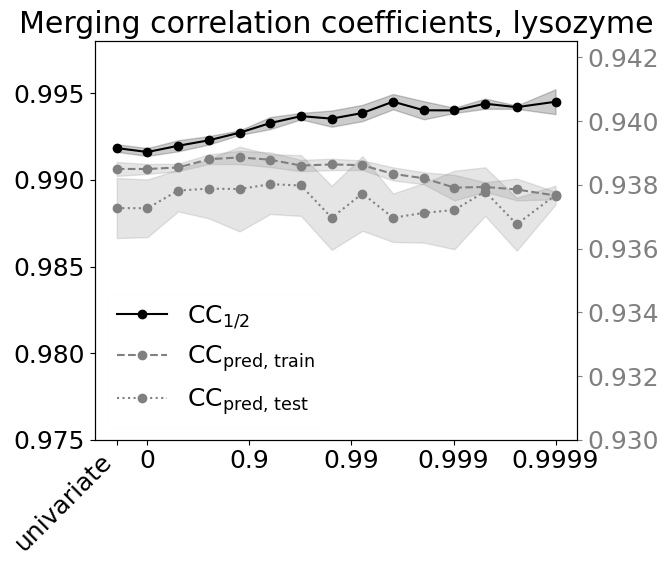

In [68]:
tmp=all_results.copy()
tmp=tmp.sort_values(by=["rDW"])

fig,ax = plt.subplots(figsize=(7,6))

lns1 = ax.plot(np.log10(1-tmp["rDW"]),tmp["CChalf"],'ko-',label=r"CC$_\text{1/2}$")
plt.fill_between(np.log10(1-tmp["rDW"]), 
                 tmp["CChalf"] - tmp["CChalf_std"], 
                 tmp["CChalf"] + tmp["CChalf_std"], 
                 color='k', alpha=0.2)

ax2 = ax.twinx()
lns2 = ax2.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_train"],'o--',color="gray",label=r"CC$_\text{pred, train}$")
ax2.fill_between(np.log10(1-tmp["rDW"]), 
                 tmp["CCpred_train"] - tmp["CCpred_train_std"], 
                 tmp["CCpred_train"] + tmp["CCpred_train_std"], 
                 color='gray', alpha=0.2)

lns3 = ax2.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_test"],'o:',color="gray",label=r"CC$_\text{pred, test}$")
ax2.fill_between(np.log10(1-tmp["rDW"]), 
                 tmp["CCpred_test"] - tmp["CCpred_test_std"], 
                 tmp["CCpred_test"] + tmp["CCpred_test_std"], 
                 color='gray', alpha=0.2)

plt.title("Merging correlation coefficients, lysozyme")
plt.xlabel("double-Wilson $r$")

#plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
ax.set_ylim([0.975,0.998])
ax2.set_ylim([0.93,0.9425])

ax2.tick_params(axis='y', colors='gray')
ax2.yaxis.label.set_color('gray')

ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower left',framealpha=0.01)

plt.tight_layout()
plt.savefig("CCs.svg",bbox_inches="tight")
plt.show()

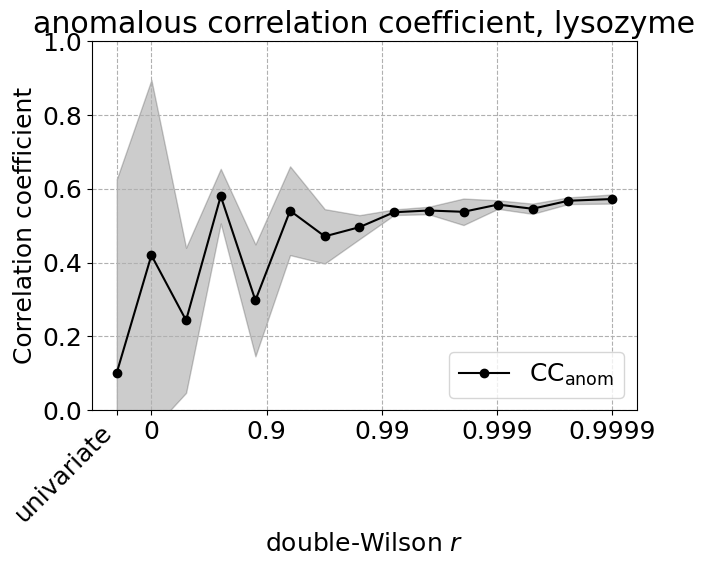

In [36]:
fig,ax = plt.subplots(figsize=(7,6))

plt.plot(np.log10(1-tmp["rDW"]),tmp["CCanom"],'ko-',label=r"CC$_\text{anom}$")
plt.fill_between(np.log10(1-tmp["rDW"]), tmp["CCanom"] - tmp["CCanom_std"], tmp["CCanom"] + tmp["CCanom_std"], color='k', alpha=0.2)

plt.grid(linestyle="--")
plt.title("anomalous correlation coefficient, lysozyme")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([0,1])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("CCanom.svg",bbox_inches="tight")
plt.show()

In [1]:
%%bash 

mkdir ./pymol
cd pymol
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_R0.99902_0720_dmin1pt8/Refine_4/mlp32_PEF_R0.99902_0720_dmin1pt8_new_refine_2.pdb ./lysozyme_refine.pdb
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_Rneg1_0720_dmin1pt8/Refine_2/mlp32_PEF_Rneg1_0720_dmin1pt8_new_refine_2.mtz lysozyme_refine_univariate.mtz
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_R0.99902_0720_dmin1pt8/Refine_2/mlp32_PEF_R0.99902_0720_dmin1pt8_new_refine_2.mtz ./lysozyme_refine_multivariate.mtz

mkdir: cannot create directory ‘./pymol’: File exists
